In [39]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle

from io import StringIO
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


df = pd.read_csv('menulog.csv')
df = df[pd.notnull(df['sentiment'])]
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)
df['class_label'] = df['sentiment'].factorize()[0]
class_label_df = df[['sentiment', 'class_label']].drop_duplicates().sort_values('class_label')
label_to_id = dict(class_label_df.values)
id_to_label = dict(class_label_df[['class_label', 'sentiment']].values)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['Customer_review'] = df['Customer_review'].apply(clean_text)

list_corpus = df["Customer_review"].tolist()
list_labels = df["class_label"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)


In [46]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap

tags_split = [tags.split(',') for tags in df['sentiment'].values]
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
train_size = int(len(df) * .8)

y_train = tags_encoded[: train_size]
y_test = tags_encoded[train_size:]

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix
     
VOCAB_SIZE = 500
train_post = df['Customer_review'].values[: train_size]
test_post = df['Customer_review'].values[train_size: ]
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

def create_model(vocab_size, num_tags):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (VOCAB_SIZE,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
model = create_model(VOCAB_SIZE, num_tags)
model.fit(X_train, y_train, epochs = 4, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Epoch 1/4
2/2 [==============================] - 0s 141ms/step - loss: 0.6867 - accuracy: 0.5192 - val_loss: 0.6620 - val_accuracy: 0.8333
Epoch 2/4
2/2 [==============================] - 0s 46ms/step - loss: 0.6481 - accuracy: 0.8077 - val_loss: 0.6342 - val_accuracy: 0.8750
Epoch 3/4
2/2 [==============================] - 0s 52ms/step - loss: 0.6114 - accuracy: 0.9375 - val_loss: 0.6064 - val_accuracy: 0.9583
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.5731 - accuracy: 0.9828
Eval loss/accuracy:[0.5731028318405151, 0.982758641242981]


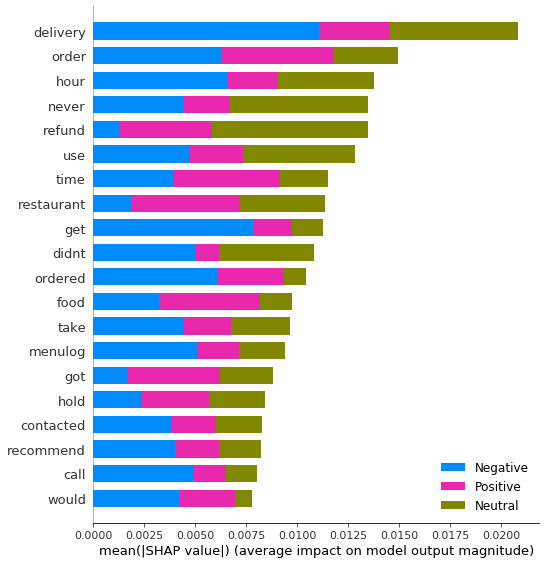

In [47]:
attrib_data = X_train[:500]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations])
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)
word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [63]:
import warnings
from lime import submodular_pick

# Remember to convert the dataframe to matrix values
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer, df['sentiment'].values, \
attrib_data, num_features=3,num_exps_desired=10)

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

TypeError: 'numpy.ndarray' object is not callable